# Documentation

**Spencer Ressel**

**2023.06.14**

This code numerically solves the governing equations from Matsuno (1966). It was mostly written by Daniel Lloveras as a project for the course ATM S 582.  

The code uses the pseudospectral method with leapfrog time differencing to solve the equations of motion

# Imports

In [131]:
import numpy as np
from numpy.fft import fft, ifft, fftfreq

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

import mjo_mean_state_diagnostics as mjo

# Define physical constants

In [28]:
GRAVITY = 9.81
EQUIVALENT_DEPTH = 250.
CORIOLIS_PARAMETER = 2.29e-11
gravity_wave_phase_speed = np.sqrt(GRAVITY*EQUIVALENT_DEPTH)
time_scale = (2*CORIOLIS_PARAMETER*gravity_wave_phase_speed)**(-1/2)
length_scale = (gravity_wave_phase_speed/(2*CORIOLIS_PARAMETER))**(1/2)
A1 = (length_scale**2)/(time_scale**3)
A2 = length_scale/(time_scale**3)
# EPS = 0.1*1/time_scale
EPS = 0

# Define simulation parameters

In [3]:
cfl = 0.2                                                        # Courant-Friedrichs-Lewy number
zonal_domain_length = 1.25e7                                     # length scale for x domain in m
meridional_domain_length = 5e6                                   # length of half y domain in m
heating_length = zonal_domain_length/5                           # length scale for heating in m
x_step_size = 2e5                                                # x grid spacing in m
y_step_size = 2e5                                                # y grid spacing in m
simulation_length = 5e6                                          # time length in s

time_step = int(cfl*x_step_size/gravity_wave_phase_speed)        # time step in s
time = np.arange(                                                # array of times
    0,
    simulation_length+time_step,
    time_step
)
x_grid = np.arange(                                               # x grid points 
    -zonal_domain_length+(zonal_domain_length/5),
    zonal_domain_length+(zonal_domain_length/5),
    x_step_size
)                                                                
y_grid = np.arange(                                               # y grid points
    -meridional_domain_length,
    meridional_domain_length,
    y_step_size
)                                                                

nt = len(time)                                                   # number of time steps
nx = len(x_grid)                                                  # number of x grid points
ny = len(y_grid)                                                  # number of y grid points

zonal_wavenumber = 2*np.pi*fftfreq(nx,x_step_size)               # zonal wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny,y_step_size)          # meridional wavenumbers

# Compute solutions

## Initial Conditions

In [4]:
### Initialize arrays
zonal_velocity = np.zeros((nt,ny,nx))
meridional_velocity = np.zeros((nt,ny,nx))
geopotential_height = np.zeros((nt,ny,nx))
symmetric_heat_source = np.zeros((ny,nx))
asymmetric_heat_source = np.zeros((ny,nx))


# zonal_velocity[0,:,:] = -np.einsum(
#     'i,j->ij',
#     (y_grid/(2*length_scale))*np.exp(-y_grid**2/(4*length_scale**2)),
#     np.sin((np.pi*x_grid)/(2*heating_length))
# )
# zonal_velocity[0,:,:][:, np.abs(x_grid) > 2*heating_length] = 0

# meridional_velocity[0,:,:] = np.einsum(
#     'i,j->ij',
#     (y_grid/(2*length_scale))*np.exp(-y_grid**2/(4*length_scale**2)),
#     np.cos((np.pi*x_grid)/(2*heating_length))
# )
# meridional_velocity[0,:,:][:, np.abs(x_grid) > heating_length] = 0

geopotential_height[0,:,:] = np.einsum(
    'i,j->ij',
    # (y_grid/(2*length_scale))*np.exp(-y_grid**2/(4*length_scale**2)),
    np.exp(-y_grid**2/(4*length_scale**2)),
    np.cos((np.pi*x_grid)/(2*heating_length))
)
geopotential_height[0,:,:][:, np.abs(x_grid) > heating_length] = 0

# ### Compute heating
# for ix in range(nx):
#     if np.abs(x_grid[ix]) <= heating_length:
#         f1 = A1*np.cos((np.pi*x_grid[ix])/(2*heating_length))
#         f2 = A2*np.cos((np.pi*x_grid[ix])/(2*heating_length))
#     else:
#         f1 = 0
#         f2 = 0
#     for iy in range(ny):
#         symmetric_heat_source[iy,ix] = f1*np.exp(-(y_grid[iy]**2)/(4*LS**2))
#         asymmetric_heat_source[iy,ix] = f2*y_grid[iy]*np.exp(-(y_grid[iy]**2)/(4*LS**2))   

### Plot initial conditions

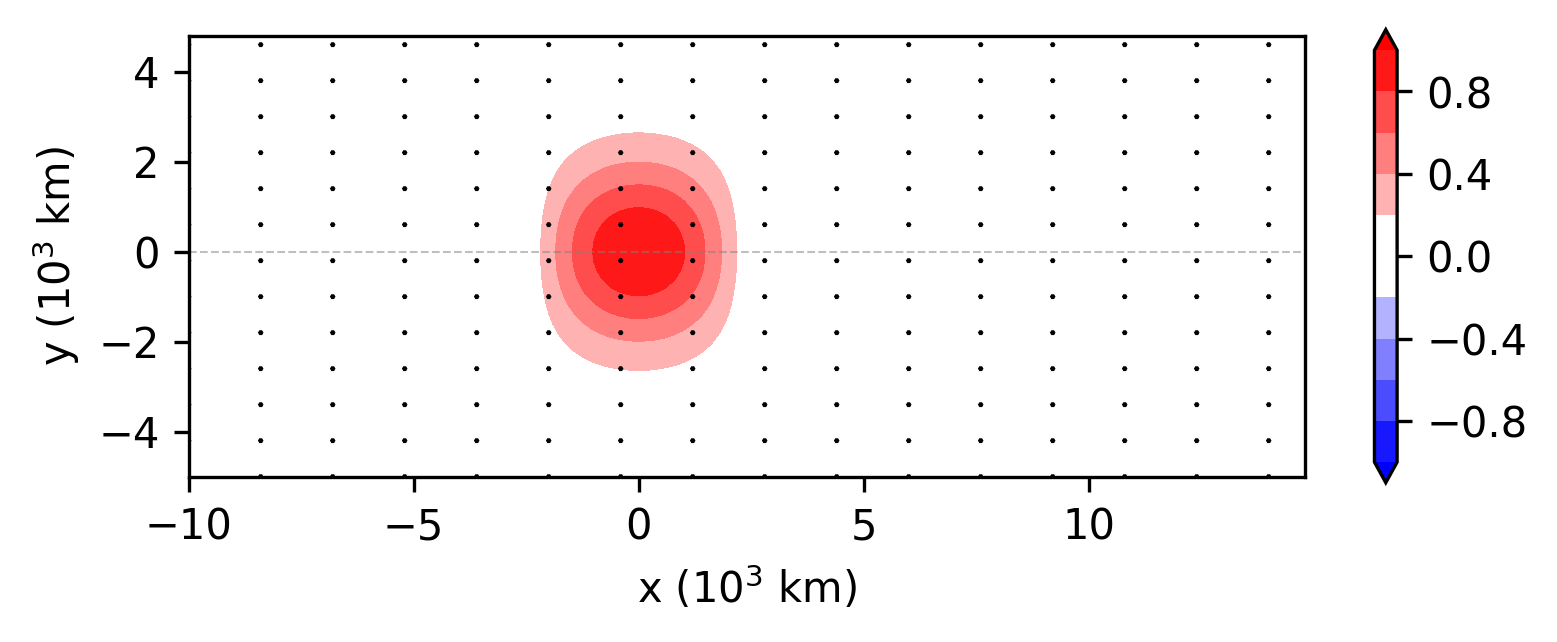

In [5]:
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)

fig, ax = plt.subplots(figsize=(6,2),dpi=300)
cont = plt.contourf(
    x_grid/1e6,
    y_grid/1e6,
    geopotential_height[0,:,:],
    levels = np.linspace(-1,1,11),
    norm=mcolors.CenteredNorm(),
    cmap=modified_cmap, 
    extend='both'
)
plt.colorbar()
quiv = plt.quiver(
    x_grid[::8]/1e6,
    y_grid[::4]/1e6,
    zonal_velocity[0,::4,::8],
    meridional_velocity[0,::4,::8],
    color='k',
    scale=15,
    width=0.005
)

plt.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

plt.xlabel('x ($10^3$ km)')
plt.ylabel('y ($10^3$ km)')
ax.set_aspect('equal')

## Solve

In [6]:
### Choose type of heating: symmetric_heat_source = symmetric, asymmetric_heat_source = antisymmetric
q = symmetric_heat_source

### Initialize leapfrog method with one step forward

### Transform to wavenumber space
ux_fft = fft(zonal_velocity[0,:,:],axis=1)
vy_fft = fft(meridional_velocity[0,:,:],axis=0)
phix_fft = fft(geopotential_height[0,:,:],axis=1)
phiy_fft = fft(geopotential_height[0,:,:],axis=0)

### Compute derivatives
dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
dphidx_fft = 1j*zonal_wavenumber[None,:]*phix_fft
dphidy_fft = 1j*meridional_wavenumber[:,None]*phiy_fft
    
### Transform back to physical space
dudx = np.real(ifft(dudx_fft,axis=1))
dvdy = np.real(ifft(dvdy_fft,axis=0))
dphidx = np.real(ifft(dphidx_fft,axis=1))
dphidy = np.real(ifft(dphidy_fft,axis=0))

### Step forward one time step
zonal_velocity[1,:,:] = zonal_velocity[0,:,:] - time_step*(
    -CORIOLIS_PARAMETER*y_grid[:,None]*meridional_velocity[0,:,:] 
    + dphidx[:,:] 
    + EPS*zonal_velocity[0,:,:]
)
meridional_velocity[1,:,:] = meridional_velocity[0,:,:] - time_step*(
    CORIOLIS_PARAMETER*y_grid[:,None]*zonal_velocity[0,:,:] 
    + dphidy[:,:] 
    + EPS*zonal_velocity[0,:,:]
)
geopotential_height[1,:,:] = geopotential_height[0,:,:] - time_step*(
    GRAVITY*EQUIVALENT_DEPTH*(dudx[:,:] + dvdy[:,:]) 
    + EPS*geopotential_height[0,:,:] 
    + q[:,:]
)

### Meridional boundary condition
meridional_velocity[1,0,:] = 0.
meridional_velocity[1,-1,:] = 0.
        
### Step forward using leapfrong time-differencing
for it in range(2,nt):
    ### Transform to spectral space
    ux_fft = fft(zonal_velocity[it-1,:,:],axis=1)
    vy_fft = fft(meridional_velocity[it-1,:,:],axis=0)
    phix_fft = fft(geopotential_height[it-1,:,:],axis=1)
    phiy_fft = fft(geopotential_height[it-1,:,:],axis=0)

    ### Compute derivatives
    dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
    dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
    dphidx_fft = 1j*zonal_wavenumber[None,:]*phix_fft
    dphidy_fft = 1j*meridional_wavenumber[:,None]*phiy_fft

    ### Transform back to physical space
    dudx = np.real(ifft(dudx_fft,axis=1))
    dvdy = np.real(ifft(dvdy_fft,axis=0))
    dphidx = np.real(ifft(dphidx_fft,axis=1))
    dphidy = np.real(ifft(dphidy_fft,axis=0))

    ### Step forward with leapfrog scheme
    zonal_velocity[it,:,:] = (1/(1+EPS*2*time_step))*(
        zonal_velocity[it-2,:,:] - 2*time_step*(
            -CORIOLIS_PARAMETER*y_grid[:,None]*meridional_velocity[it-1,:,:] 
            + dphidx[:,:]
        )
    )
    meridional_velocity[it,:,:] = (1/(1+EPS*2*time_step))*(
        meridional_velocity[it-2,:,:] - 2*time_step*(
            CORIOLIS_PARAMETER*y_grid[:,None]*zonal_velocity[it-1,:,:] 
            + dphidy[:,:]
        )
    )
    geopotential_height[it,:,:] = (1/(1+EPS*2*time_step))*(
        geopotential_height[it-2,:,:] - 2*time_step*(
            GRAVITY*EQUIVALENT_DEPTH*(dudx[:,:] + dvdy[:,:]) 
            + q[:,:]
        )
    )
    
    ### Meridional boundary condition
    meridional_velocity[it,0,:] = 0.

## Plot solutions

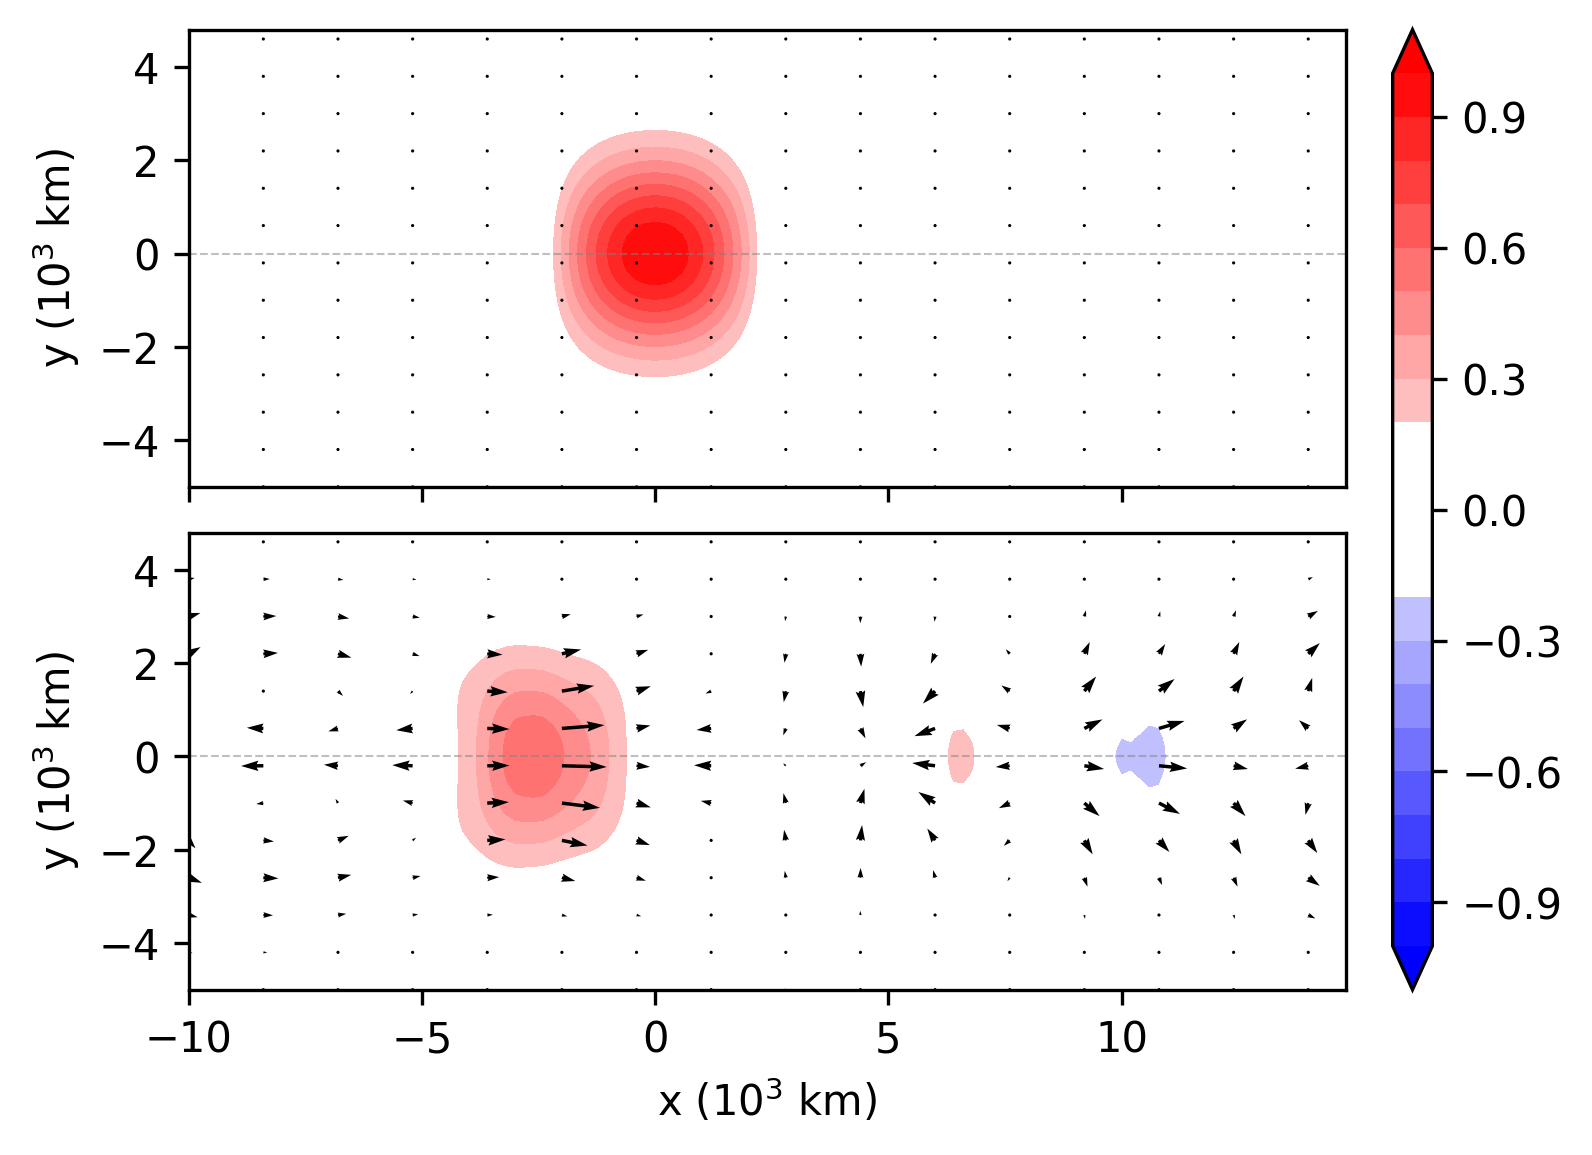

In [7]:
fig = plt.figure(figsize=(6,4), dpi=300)
gs = GridSpec(2, 2, figure=fig, width_ratios = [30,1])
gs.update(left=0.1, right=0.8, top=0.9, bottom=0.1, hspace=0.1, wspace=0.05)

############## At simulation beginning ####################
ax0 = fig.add_subplot(gs[0,0])
cbar_ax0 = fig.add_subplot(gs[:,1])

cont0 = ax0.contourf(
    x_grid/1e6,
    y_grid/1e6,
    geopotential_height[0,:,:],
    levels=np.linspace(-1,1,21),
    cmap=modified_cmap, 
    extend='both'
)
cbar0 = fig.colorbar(cont0, cax=cbar_ax0)

quiv = ax0.quiver(
    x_grid[::8]/1e6,
    y_grid[::4]/1e6,
    zonal_velocity[0,::4,::8],
    meridional_velocity[0,::4,::8],
    color='k',
    scale=0.2,
    width=0.003
)

ax0.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

# ax0.set_xlabel('x ($10^3$ km)')
ax0.set_xticklabels([])
ax0.set_ylabel('y ($10^3$ km)')
ax0.set_aspect('equal')

############## At simulation end ####################
ax1 = fig.add_subplot(gs[1,0])
# cbar_ax1 = fig.add_subplot(gs[1,1])

cont1 = ax1.contourf(
    x_grid/1e6,
    y_grid/1e6,
    geopotential_height[-1,:,:],
    levels=np.linspace(-1,1,21),
    cmap=modified_cmap, 
    extend='both'
)
# cbar1 = fig.colorbar(cont1, cax=cbar_ax1)

quiv = ax1.quiver(
    x_grid[::8]/1e6,
    y_grid[::4]/1e6,
    zonal_velocity[-1,::4,::8],
    meridional_velocity[-1,::4,::8],
    color='k',
    scale=0.2,
    width=0.003
)

ax1.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

ax1.set_xlabel('x ($10^3$ km)')
ax1.set_ylabel('y ($10^3$ km)')
ax1.set_aspect('equal')

# Animate solutions

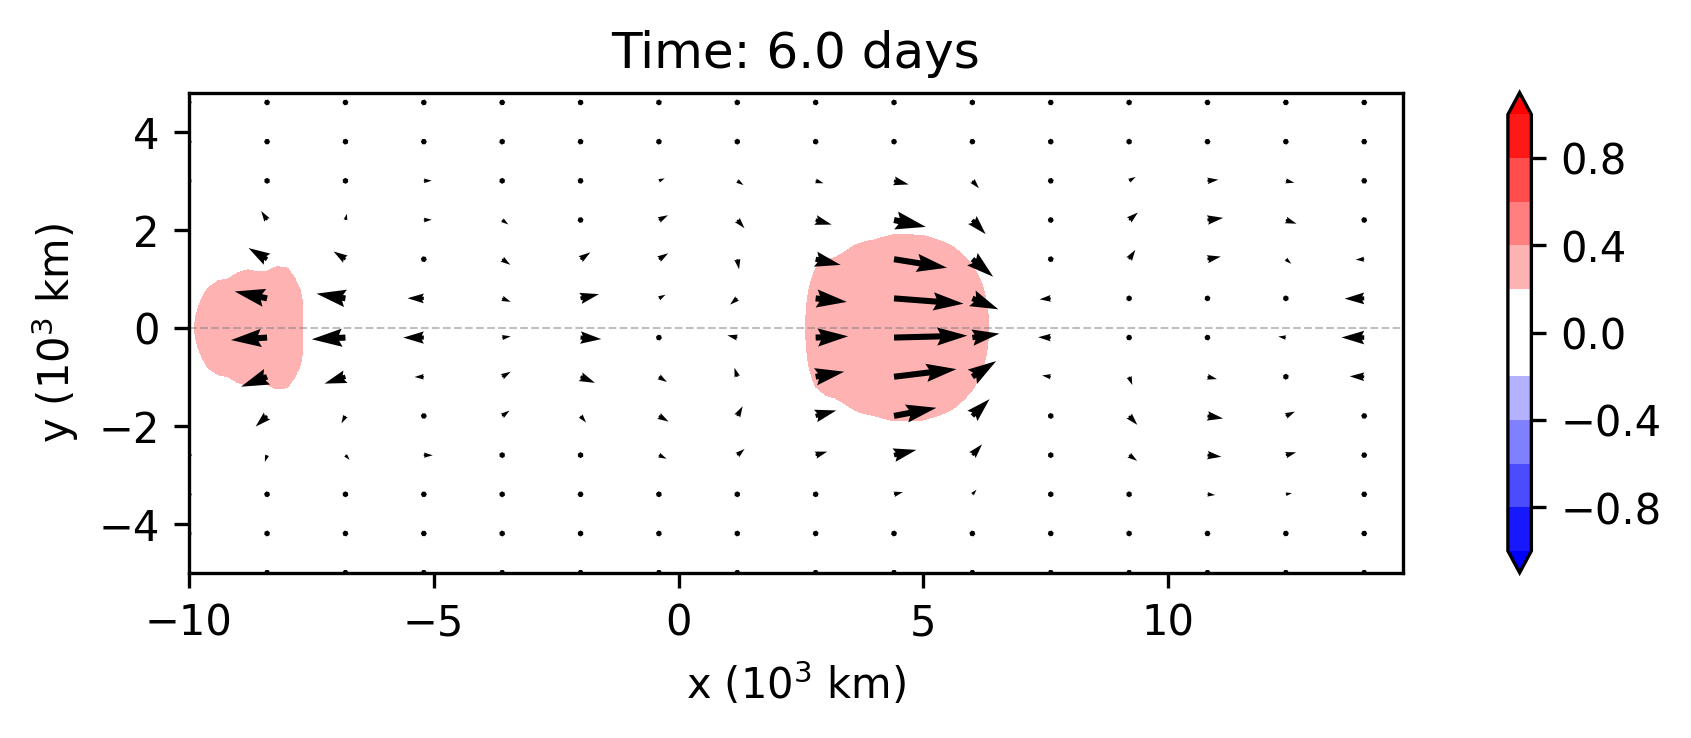

In [376]:
fig = plt.figure(figsize=(6,2),dpi=300)
gs = GridSpec(1, 2, figure=fig, width_ratios=[60,1])
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.01)
ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

ax.set_title(f"Time: {time[0]//(24*3600)} days")
contour_args = {
    'cmap':modified_cmap,
    'norm':mcolors.CenteredNorm(),
    'levels':np.linspace(-1,1,11),
    'extend':'both'
}

quiver_args = {
    'color':'black',
    'scale':0.2,
    'width':0.005
}

cont = ax.contourf(
    x_grid/1e6,
    y_grid/1e6,
    geopotential_height[0,:,:],
    **contour_args
)
cbar = fig.colorbar(cont, cax=cbar_ax)
quiv = ax.quiver(
    x_grid[::8]/1e6,
    y_grid[::4]/1e6,
    zonal_velocity[0,::4,::8],
    meridional_velocity[0,::4,::8],
    **quiver_args
)
ax.set_xlabel('x ($10^3$ km)')
ax.set_ylabel('y ($10^3$ km)')
ax.set_aspect('equal')

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

n_frames = 50
# frame_interval = 6197//n_frames
frame_interval = 15

def update(frame):
    
    ax.set_title(f"Time: {time[frame_interval*frame]//(24*3600)} days")
    cont = ax.contourf(
        x_grid/1e6,
        y_grid/1e6,
        geopotential_height[frame_interval*frame,:,:],
        **contour_args
    )
    quiv = ax.quiver(
        x_grid[::8]/1e6,
        y_grid[::4]/1e6,
        zonal_velocity[frame_interval*frame,::4,::8],
        meridional_velocity[frame_interval*frame,::4,::8],
        **quiver_args
    )
    
    return cont, quiv
    
anim = FuncAnimation(fig, update, frames=n_frames, interval=600)

anim.save('solver_test.mp4', dpi=300)

# Filtered Solutions

In [8]:
low_u = mjo.butter_lowpass_filter(zonal_velocity.T, 1/(5*24*3600), 1/time_step).T
low_v = mjo.butter_lowpass_filter(meridional_velocity.T, 1/(5*24*3600), 1/time_step).T
low_phi = mjo.butter_lowpass_filter(geopotential_height.T, 1/(5*24*3600), 1/time_step).T

In [9]:
# phase_speed = np.einsum('i,j->ikj', zonal_wavenumber, frequencies)
phase_speed = -np.repeat(np.einsum('i,j->ji', zonal_wavenumber, frequencies)[:, np.newaxis,:], len(y_grid), axis=1)

u_fft = np.fft.fft2(low_u, axes=[0,2])
u_fft[np.where(phase_speed>=0)] = 0
u_east = np.real(np.fft.ifft2(u_fft, axes=[0,2]))

v_fft = np.fft.fft2(low_v, axes=[0,2])
v_fft[np.where(phase_speed>=0)] = 0
v_east = np.real(np.fft.ifft2(v_fft, axes=[0,2]))

phi_fft = np.fft.fft2(low_phi, axes=[0,2])
phi_fft[np.where(phase_speed>=0)] = 0
phi_east = np.real(np.fft.ifft2(phi_fft, axes=[0,2]))
# plt.contourf(np.real(test)[0,:,:], cmap='coolwarm', norm=mcolors.CenteredNorm())

NameError: name 'frequencies' is not defined

## Animate filtered solutions

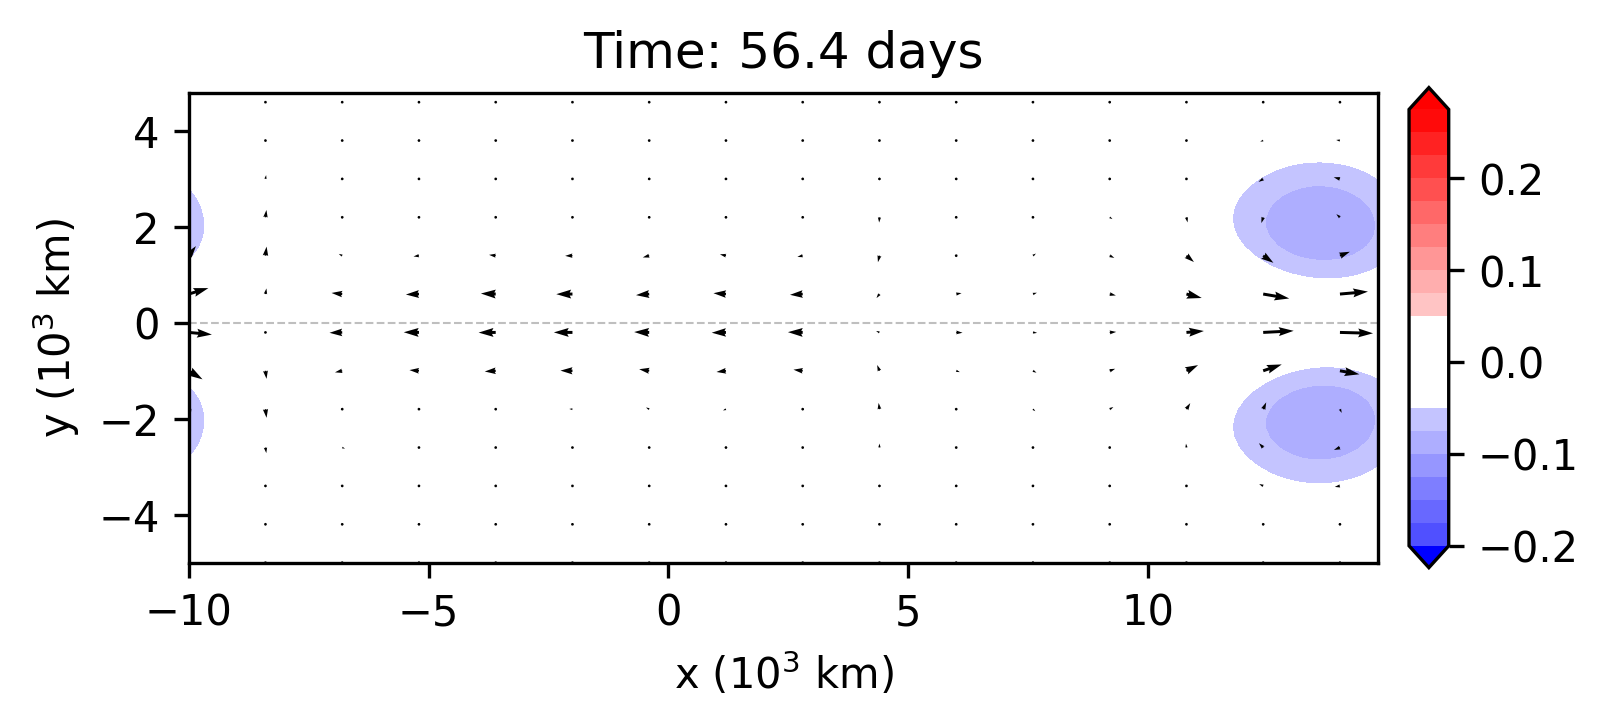

In [216]:
fig = plt.figure(figsize=(6,2),dpi=300)
gs = GridSpec(1, 2, figure=fig, width_ratios=[30,1])
gs.update(left=0.1, right=0.8, top=0.9, bottom=0.1, wspace=0.05)
ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])


ax.set_title(f"Time: {time[0]/(24*3600):0.1f} days")
contour_args = {
    'cmap':modified_cmap,
    'norm':mcolors.CenteredNorm(),
    'levels':np.arange(-0.2,0.3,0.025),
    'extend':'both'
}

quiver_args = {
    'color':'black',
    'scale':0.15,
    'width':0.0025
}

cont = ax.contourf(
    x_grid/1e6,
    y_grid/1e6,
    phi_east[0,:,:],
    **contour_args
)
cbar = fig.colorbar(cont, cax=cbar_ax)
cbar.set_ticks(contour_args['levels'][::4])

quiv = ax.quiver(
    x_grid[::8]/1e6,
    y_grid[::4]/1e6,
    u_east[0,::4,::8],
    v_east[0,::4,::8],
    **quiver_args
)
ax.set_xlabel('x ($10^3$ km)')
ax.set_ylabel('y ($10^3$ km)')
ax.set_aspect('equal')

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

n_frames = 100
frame_interval = 6197//n_frames
# frame_interval = 25

def update(frame):
    
    ax.set_title(f"Time: {time[frame_interval*frame]/(24*3600):0.1f} days")
    cont = ax.contourf(
        x_grid/1e6,
        y_grid/1e6,
        phi_east[frame_interval*frame,:,:],
        **contour_args
    )
    quiv = ax.quiver(
        x_grid[::8]/1e6,
        y_grid[::4]/1e6,
        u_east[frame_interval*frame,::4,::8],
        v_east[frame_interval*frame,::4,::8],
        **quiver_args
    )
    
    return cont, quiv
    
anim = FuncAnimation(fig, update, frames=n_frames, interval=500)

anim.save('Rossby wave animation.mp4', dpi=300)

# Ahmed (2021) Solutions

## Physical Constants

In [219]:
GRAVITY = 9.81
EQUIVALENT_DEPTH = 250.
CORIOLIS_PARAMETER = 2.29e-11
SECONDS_PER_DAY = 86400
gravity_wave_phase_speed = np.sqrt(GRAVITY*EQUIVALENT_DEPTH)
time_scale = (2*CORIOLIS_PARAMETER*gravity_wave_phase_speed)**(-1/2)
length_scale = (gravity_wave_phase_speed/(2*CORIOLIS_PARAMETER))**(1/2)

# Ahmed (2021) constants
gross_dry_stability = 3.12e4
gross_moisture_stratification = 0.75*gross_dry_stability
moisture_sensitivity = 1/(6*3600)
temperature_sensitivity = 1/(2*3600)
# moisture_sensitivity = 0
# temperature_sensitivity = 0
cloud_radiative_parameter = 0.2
zonal_moistening = 5e-4
meridional_moistening = 9e-10

## Simulation Parameters

In [228]:
# Courant-Friedrichs-Lewy number
# cfl = 0.1

# length scale for x domain in m
zonal_domain_length = 1.28e7

# length of half y domain in m
meridional_domain_length = 5e6

# length scale for heating in m
heating_length = zonal_domain_length/4

# x grid spacing in m
x_step_size = 2e5

# y grid spacing in m
# y_step_size = 1e5
y_step_size = 2e5

# time step in seconds
# time_step = int(cfl*x_step_size/gravity_wave_phase_speed)

# time length in days
n_days = 120
simulation_length = n_days*SECONDS_PER_DAY

# array of times
# time = np.arange(                                                
#     0,
#     simulation_length+time_step,
#     time_step
# )

time = np.linspace(
    0, 
    simulation_length, 
    2**14
)

time_step = np.diff(time)[0]

# x grid points 
x_grid = np.arange(                                               
    -zonal_domain_length+(zonal_domain_length/5),
    zonal_domain_length+(zonal_domain_length/5),
    x_step_size
)

# y grid points
y_grid = np.arange(                                               
    -meridional_domain_length,
    meridional_domain_length,
    y_step_size
)
y_plot_spacing = int((1/10)*2*meridional_domain_length/y_step_size)
x_plot_spacing = int((1/15)*2*zonal_domain_length/x_step_size)


# number of time steps
nt = len(time)

# number of x grid points
nx = len(x_grid)

# number of y grid points
ny = len(y_grid)

# zonal wavenumbers
zonal_wavenumber = 2*np.pi*fftfreq(nx,x_step_size)

# meridional wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny,y_step_size)

# frequencies
frequencies = 2*np.pi*fftfreq(nt, time_step)

print(f"Lx = {zonal_domain_length/1e3:0.0f} km, Δx = {x_step_size/1e3:0.0f} km, nx = {nx:0.0f}")
print(f"Ly = {2*meridional_domain_length/1e3:0.0f} km, Δy = {y_step_size/1e3:0.0f} km, ny = {ny:0.0f}")
print(f"T = {simulation_length/SECONDS_PER_DAY:0.1f} days, Δt = {time_step:0.1f} seconds, nt = {nt:0.0f}")
print(f"CFL = {gravity_wave_phase_speed*time_step/x_step_size:0.2f}")
if (gravity_wave_phase_speed*time_step/x_step_size > 1):
    print("CFL > 1, numerically unstable!!")

Lx = 12800 km, Δx = 200 km, nx = 128
Ly = 10000 km, Δy = 200 km, ny = 50
T = 120.0 days, Δt = 632.9 seconds, nt = 16384
CFL = 0.16


## Initial Conditions

In [229]:
### Initialize arrays
zonal_velocity = np.zeros((nt,ny,nx))
meridional_velocity = np.zeros((nt,ny,nx))
column_temperature = np.zeros((nt,ny,nx))
column_moisture = np.zeros((nt, ny,nx))

# zonal_velocity[0,:,:] = -np.einsum(
#     'i,j->ij',
#     (y_grid/(2*length_scale))*np.exp(-y_grid**2/(4*length_scale**2)),
#     np.sin((np.pi*x_grid)/(2*heating_length))
# )
# zonal_velocity[0,:,:][:, np.abs(x_grid) > 2*heating_length] = 0

# meridional_velocity[0,:,:] = np.einsum(
#     'i,j->ij',
#     (y_grid/(2*length_scale))*np.exp(-y_grid**2/(4*length_scale**2)),
#     np.cos((np.pi*x_grid)/(2*heating_length))
# )
# meridional_velocity[0,:,:][:, np.abs(x_grid) > heating_length] = 0

column_temperature[0,:,:] = np.einsum(
    'i,j->ij',
    # (y_grid/(2*length_scale))*np.exp(-y_grid**2/(4*length_scale**2)),
    np.exp(-y_grid**2/(4*length_scale**2)),
    np.sin((np.pi*x_grid)/(2*heating_length))
)
column_temperature[0,:,:][:, np.abs(x_grid) > 2*heating_length] = 0

# column_moisture[0,:,:] = np.einsum(
#     'i,j->ij',
#     # (y_grid/(2*length_scale))*np.exp(-y_grid**2/(4*length_scale**2)),
#     np.exp(-y_grid**2/(4*length_scale**2)),
#     np.sin((np.pi*x_grid)/(2*heating_length))
# )
# column_moisture[0,:,:][:, np.abs(x_grid) > heating_length] = 0

### Plot initial conditions

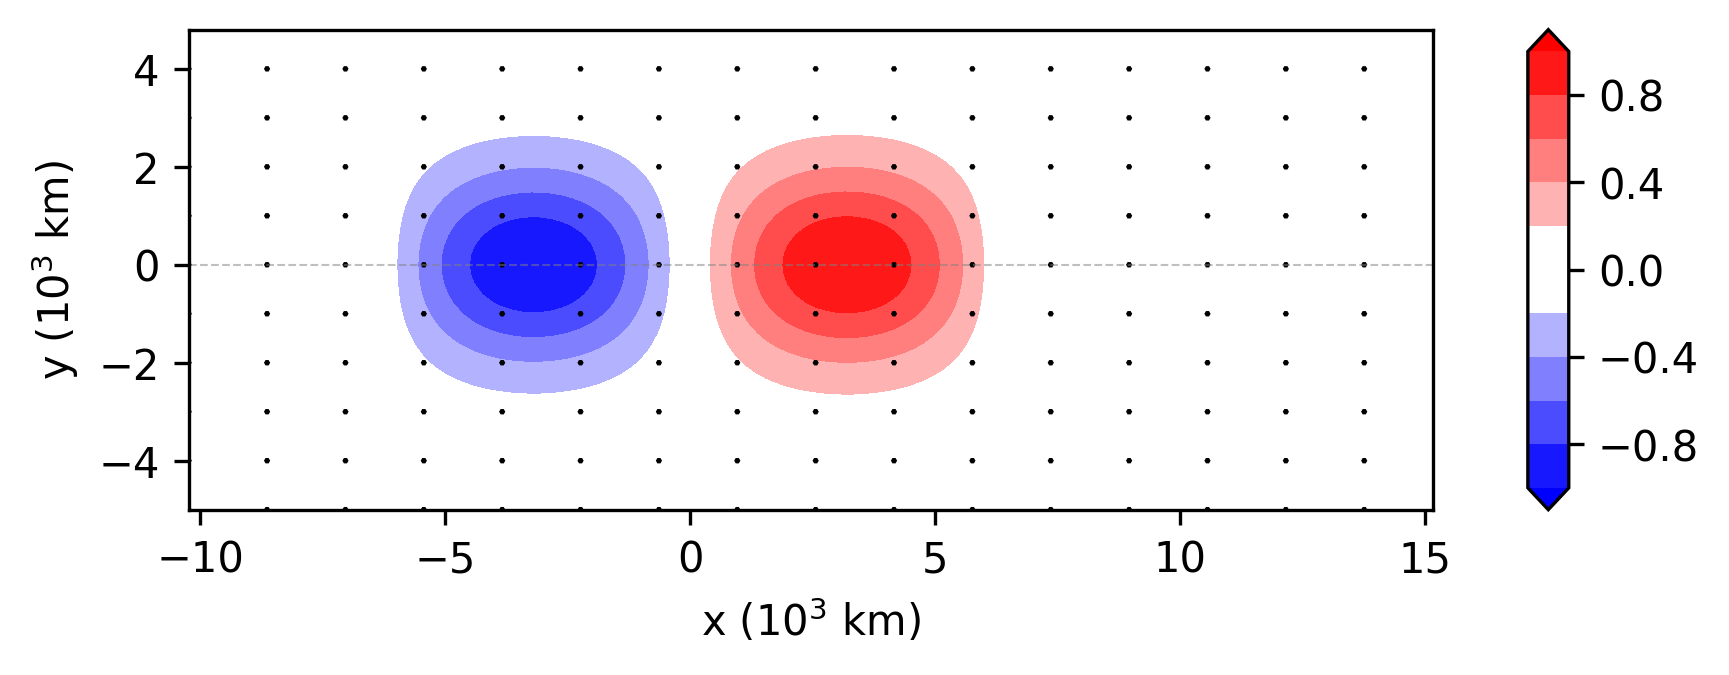

In [230]:
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)
frame = 0

fig = plt.figure(figsize=(6,2),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,3], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05)

Tbar_ax = fig.add_subplot(gs[-1])
ax = fig.add_subplot(gs[0])

T_cont = ax.contourf(
    x_grid/1e6,
    y_grid/1e6,
    column_temperature[frame,:,:],
    levels = np.linspace(-1,1,11),
    norm=mcolors.CenteredNorm(),
    cmap=modified_cmap, 
    extend='both'
)

Tbar = fig.colorbar(T_cont, cax=Tbar_ax)

# q_cont = plt.contour(
#     x_grid/1e6,
#     y_grid/1e6,
#     column_moisture[frame,:,:],
#     levels = np.delete(np.linspace(-0.5,0.5,11), [5]),
#     norm=mcolors.CenteredNorm(),
#     colors='black',
#     # alpha=0.5
# )
# qbar = fig.colorbar(q_cont, cax=qbar_ax)
# qbar_ax.yaxis.set_ticks_position('left')


quiv = ax.quiver(
    x_grid[::x_plot_spacing]/1e6,
    y_grid[::y_plot_spacing]/1e6,
    zonal_velocity[frame,::y_plot_spacing,::x_plot_spacing],
    meridional_velocity[frame,::y_plot_spacing,::x_plot_spacing],
    color='k',
    scale=15,
    width=0.005
)

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

ax.set_xlabel('x ($10^3$ km)')
ax.set_ylabel('y ($10^3$ km)')
ax.set_aspect('equal')

## Solve

In [231]:
### Initialize leapfrog method with one step forward

### Transform to wavenumber space
ux_fft = fft(zonal_velocity[0,:,:],axis=1)
vy_fft = fft(meridional_velocity[0,:,:],axis=0)
Tx_fft = fft(column_temperature[0,:,:],axis=1)
Ty_fft = fft(column_temperature[0,:,:],axis=0)

### Compute derivatives
dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft
    
### Transform back to physical space
dudx = np.real(ifft(dudx_fft,axis=1))
dvdy = np.real(ifft(dvdy_fft,axis=0))
dTdx = np.real(ifft(dTdx_fft,axis=1))
dTdy = np.real(ifft(dTdy_fft,axis=0))

### Step forward one time step
zonal_velocity[1,:,:] = zonal_velocity[0,:,:] - time_step*(
    - CORIOLIS_PARAMETER*y_grid[:,None]*meridional_velocity[0,:,:] 
    + (gravity_wave_phase_speed**2/gross_dry_stability)*dTdx[:,:]
)

meridional_velocity[1,:,:] = meridional_velocity[0,:,:] - time_step*(
    + CORIOLIS_PARAMETER*y_grid[:,None]*zonal_velocity[0,:,:] 
    + (gravity_wave_phase_speed**2/gross_dry_stability)*dTdy[:,:]
)

column_temperature[1,:,:] = column_temperature[0,:,:] - time_step*(
    + gross_dry_stability*(dudx[:,:] + dvdy[:,:]) 
    + temperature_sensitivity*(1+cloud_radiative_parameter)*column_temperature[0,:,:]
    - moisture_sensitivity*(1+cloud_radiative_parameter)*column_moisture[0,:,:]
)

column_moisture[1,:,:] = column_moisture[0,:,:] - time_step*(
    - zonal_moistening*zonal_velocity[0,:,:]
    + meridional_moistening*y_grid[:,None]*meridional_velocity[0,:,:] 
    - gross_moisture_stratification*(dudx[:,:] + dvdy[:,:]) 
    - temperature_sensitivity*column_temperature[0,:,:]
    + moisture_sensitivity*column_moisture[0,:,:]
    
)

### Meridional boundary condition
meridional_velocity[1,0,:] = 0.
meridional_velocity[1,-1,:] = 0.
        
### Step forward using leapfrong time-differencing
for it in tqdm(range(2,nt)):
    ### Transform to spectral space
    ux_fft = fft(zonal_velocity[it-1,:,:],axis=1)
    vy_fft = fft(meridional_velocity[it-1,:,:],axis=0)
    Tx_fft = fft(column_temperature[it-1,:,:],axis=1)
    Ty_fft = fft(column_temperature[it-1,:,:],axis=0)

    ### Compute derivatives
    dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
    dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
    dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
    dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft

    ### Transform back to physical space
    dudx = np.real(ifft(dudx_fft,axis=1))
    dvdy = np.real(ifft(dvdy_fft,axis=0))
    dTdx = np.real(ifft(dTdx_fft,axis=1))
    dTdy = np.real(ifft(dTdy_fft,axis=0))

    ### Step forward with leapfrog scheme
    zonal_velocity[it,:,:] = (zonal_velocity[it-2,:,:] - 2*time_step*(
        - CORIOLIS_PARAMETER*y_grid[:,None]*meridional_velocity[it-1,:,:] 
        + (gravity_wave_phase_speed**2/gross_dry_stability)*dTdx[:,:])
    )
    
    meridional_velocity[it,:,:] = (meridional_velocity[it-2,:,:] - 2*time_step*(
        + CORIOLIS_PARAMETER*y_grid[:,None]*zonal_velocity[it-1,:,:] 
        + (gravity_wave_phase_speed**2/gross_dry_stability)*dTdy[:,:])
    )
    
    column_temperature[it,:,:] = (1/(1+2*temperature_sensitivity*(1+cloud_radiative_parameter)*time_step))*(
        column_temperature[it-2,:,:] 
        - 2*time_step*(
            + gross_dry_stability*(dudx[:,:] + dvdy[:,:])
            - moisture_sensitivity*(1+cloud_radiative_parameter)*column_moisture[it-1,:,:]
        )
    )
    
    column_moisture[it,:,:] = (1/(1+2*moisture_sensitivity*time_step))*(
        column_moisture[it-2,:,:] 
        - 2*time_step*(
            - zonal_moistening*zonal_velocity[it-1,:,:]
            + meridional_moistening*y_grid[:,None]*meridional_velocity[it-1,:,:] 
            - gross_moisture_stratification*(dudx[:,:] + dvdy[:,:])
            - temperature_sensitivity*column_temperature[0,:,:]
        )
    )
    
    ### Meridional boundary condition
    meridional_velocity[it,0,:] = 0.
    meridional_velocity[it,-1,:] = 0.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16382/16382 [00:25<00:00, 649.88it/s]


## Plot Solutions

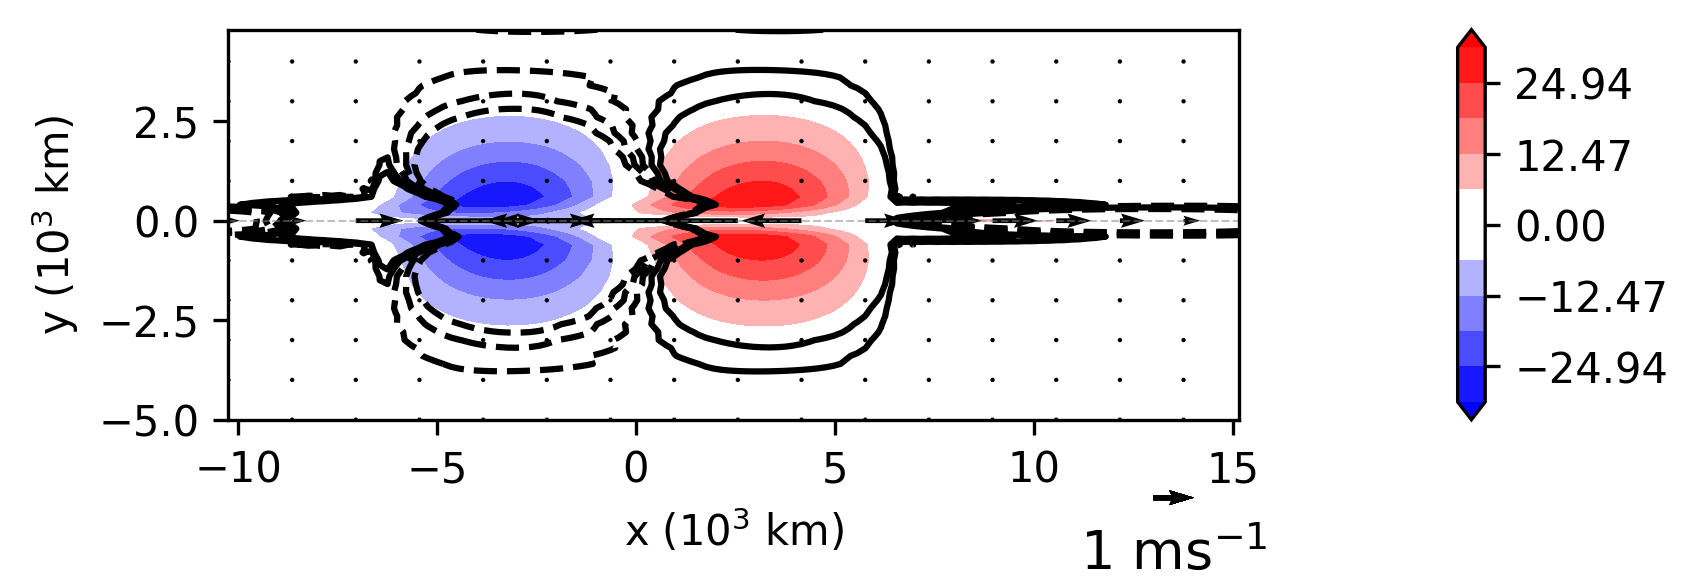

In [232]:
modified_cmap = mjo.modified_colormap('bwr', 'white', 0.15, 0.05)
frame = -1000

fig = plt.figure(figsize=(6,2),dpi=300)
gs = GridSpec(1, 2, width_ratios = [100,2], figure=fig)
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.25, wspace=0.05)

Tbar_ax = fig.add_subplot(gs[-1])
ax = fig.add_subplot(gs[0])

# scale = 5/zonal_velocity.max()
magnitude = np.sqrt(zonal_velocity**2 + meridional_velocity**2)
scale = 5/np.max(magnitude)

T_cont = ax.contourf(
    x_grid/1e6,
    y_grid/1e6,
    column_temperature[frame,:,:]*scale,
    levels = np.linspace(-1*scale,1*scale,11),
    norm=mcolors.CenteredNorm(),
    cmap=modified_cmap, 
    extend='both'
)

Tbar = fig.colorbar(T_cont, cax=Tbar_ax)

q_cont = plt.contour(
    x_grid/1e6,
    y_grid/1e6,
    column_moisture[frame,:,:]*scale,
    levels = np.delete(np.linspace(-0.5*scale,0.5*scale,6), [5]),
    norm=mcolors.CenteredNorm(),
    colors='black',
    # alpha=0.5
)
# qbar = fig.colorbar(q_cont, cax=qbar_ax)
# qbar_ax.yaxis.set_ticks_position('left')


quiv = ax.quiver(
    x_grid[::x_plot_spacing]/1e6,
    y_grid[::y_plot_spacing]/1e6,
    zonal_velocity[frame,::y_plot_spacing,::x_plot_spacing]*scale,
    meridional_velocity[frame,::y_plot_spacing,::x_plot_spacing]*scale,
    color='k',
    scale_units='xy', 
    units='xy',
    # angles='xy',
    # pivot='middle',
    scale=1,
)

ax.quiverkey(
    quiv, 
    X=0.935, Y=-.2, U=1.0,
    label='1 $\\mathrm{ms}^{-1}$',
    labelpos='S',
    color='black',
    fontproperties={'size': '13'}
)

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

ax.set_xlabel('x ($10^3$ km)')
ax.set_ylabel('y ($10^3$ km)')
ax.set_aspect('equal')

## Filtered Solutions

In [236]:
cutoff_days = 20

low_u = mjo.butter_lowpass_filter(zonal_velocity.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_v = mjo.butter_lowpass_filter(meridional_velocity.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_T = mjo.butter_lowpass_filter(column_temperature.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_q = mjo.butter_lowpass_filter(column_moisture.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T

In [237]:
# phase_speed = np.einsum('i,j->ikj', zonal_wavenumber, frequencies)
frequencies = np.fft.fftfreq(len(time), 1/time_step)
phase_speed = -np.repeat(np.einsum('i,j->ji', zonal_wavenumber, frequencies)[:, np.newaxis,:], len(y_grid), axis=1)

u_fft = np.fft.fft2(low_u, axes=[0,2])
u_fft[np.where(phase_speed<=0)] = 0
u_east = np.real(np.fft.ifft2(u_fft, axes=[0,2]))

v_fft = np.fft.fft2(low_v, axes=[0,2])
v_fft[np.where(phase_speed<=0)] = 0
v_east = np.real(np.fft.ifft2(v_fft, axes=[0,2]))

T_fft = np.fft.fft2(low_T, axes=[0,2])
T_fft[np.where(phase_speed<=0)] = 0
T_east = np.real(np.fft.ifft2(T_fft, axes=[0,2]))

q_fft = np.fft.fft2(low_q, axes=[0,2])
q_fft[np.where(phase_speed<=0)] = 0
q_east = np.real(np.fft.ifft2(q_fft, axes=[0,2]))
# plt.contourf(np.real(test)[0,:,:], cmap='coolwarm', norm=mcolors.CenteredNorm())

In [10]:
# # q_fft = np.fft.fft2(low_q, axes=[0,2])
# mask = np.zeros_like(low_u)
# mask[:,:,10] = 1

# u_fft = np.fft.fft2(low_u, axes=[0,2])
# u_fft_masked = u_fft*mask
# u_1 = np.real(np.fft.ifft2(u_fft_masked, axes=[0,2]))

# v_fft = np.fft.fft2(low_v, axes=[0,2])
# v_fft_masked = v_fft*mask
# v_1 = np.real(np.fft.ifft2(v_fft_masked, axes=[0,2]))

# T_fft = np.fft.fft2(low_T, axes=[0,2])
# T_fft_masked = T_fft*mask
# T_1 = np.real(np.fft.ifft2(T_fft_masked, axes=[0,2]))

# q_fft = np.fft.fft2(low_q, axes=[0,2])
# q_fft_masked = q_fft*mask
# q_1 = np.real(np.fft.ifft2(q_fft_masked, axes=[0,2]))

## Animation

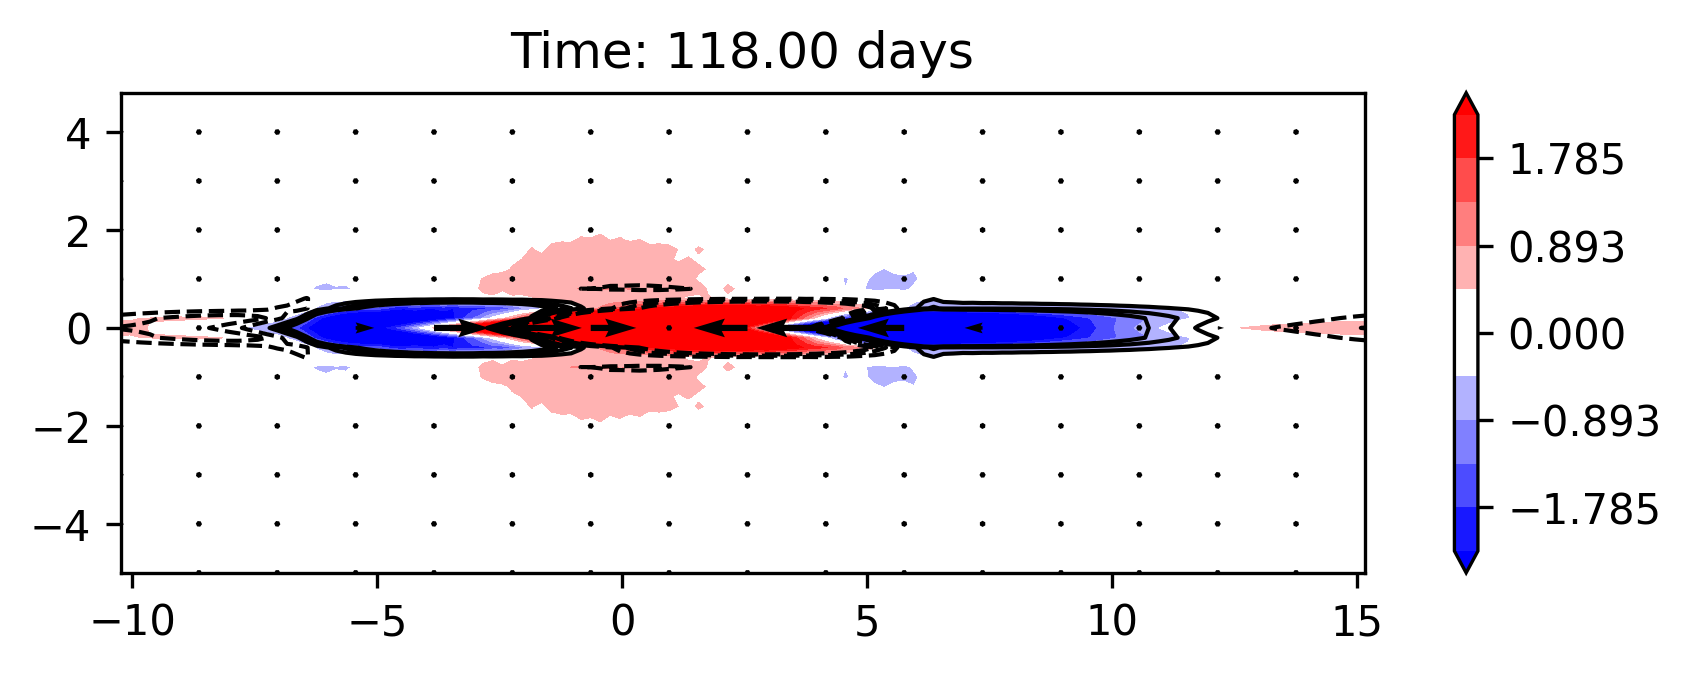

In [239]:
# u_plotting_var = zonal_velocity
# v_plotting_var = meridional_velocity
# T_plotting_var = column_temperature
# q_plotting_var = column_moisture

# u_plotting_var = low_u
# v_plotting_var = low_v
# T_plotting_var = low_T
# q_plotting_var = low_q

u_plotting_var = u_east
v_plotting_var = v_east
T_plotting_var = T_east
q_plotting_var = q_east

magnitude = np.sqrt(u_plotting_var**2 + v_plotting_var**2)
scale = 5/np.max(magnitude)

# Animation parameters
# plotting_index = 0
starting_frame = int(10*SECONDS_PER_DAY/time_step)
n_frames = 110
frame_interval = int((nt-starting_frame)/n_frames)
# frame_interval = SECONDS_PER_DAY//time_step

fig = plt.figure(figsize=(6,2),dpi=300)
gs = GridSpec(1, 2, figure=fig, width_ratios=[60,1])
gs.update(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.01)
ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

ax.set_title(f"Time: {time[starting_frame]//SECONDS_PER_DAY} days")
contourf_args = {
    'cmap':modified_cmap,
    'norm':mcolors.CenteredNorm(),
    'levels':np.linspace(-0.1*scale,0.1*scale,11),
    # 'levels':11,
    'extend':'both'
}

contour_args = {
    'levels':np.delete(np.linspace(-1*scale,1*scale,7),[3]),
    # 'levels':np.delete(np.linspace(-800,800,11),[4,5,6]),
    # 'levels':5,
    'colors':'black',
    'linewidths':1
}

quiver_args = {
    'color':'black',
    'width':0.005,
    'angles':'xy',
    'scale_units':'xy',
    'scale':1
}

contf = ax.contourf(
    x_grid/1e6,
    y_grid/1e6,
    T_plotting_var[starting_frame,:,:]*scale,
    **contourf_args
)
cbar = fig.colorbar(contf, cax=cbar_ax)

cont = ax.contour(
    x_grid/1e6,
    y_grid/1e6,
    q_plotting_var[starting_frame,:,:]*scale,
    **contour_args

)

quiv = ax.quiver(
    x_grid[::8]/1e6,
    y_grid[::4]/1e6,
    u_plotting_var[starting_frame,::4,::8]*scale,
    v_plotting_var[starting_frame,::4,::8]*scale,
    **quiver_args
)

ax.quiverkey(quiv, X=0.3, Y=1.1, U=1,
             label='Quiver key, length = '+str(1)+' m/s', labelpos='E')

ax.set_xlabel('x ($10^3$ km)')
ax.set_ylabel('y ($10^3$ km)')
ax.set_ylim(-2,2)
ax.set_aspect('equal')

ax.axhline(y=0, ls='--', alpha=0.5, color='gray', lw=0.5)

def update(current_frame):
        
    ax.clear()
    
    plotting_index = int(starting_frame + frame_interval*(current_frame))
    
    ax.set_title(f"Time: {time[plotting_index]//SECONDS_PER_DAY} days")

    contf = ax.contourf(
        x_grid/1e6,
        y_grid/1e6,
        T_plotting_var[plotting_index,:,:]*scale,
        **contourf_args   
    )
    
    cont = ax.contour(
        x_grid/1e6,
        y_grid/1e6,
        q_plotting_var[plotting_index,:,:]*scale,
        **contour_args
    )
    
    quiv = ax.quiver(
        x_grid[::x_plot_spacing]/1e6,
        y_grid[::y_plot_spacing]/1e6,
        u_plotting_var[plotting_index,::y_plot_spacing,::x_plot_spacing]*scale,
        v_plotting_var[plotting_index,::y_plot_spacing,::x_plot_spacing]*scale,
        **quiver_args
    )
    
    return contf, cont, quiv,
    
anim = FuncAnimation(fig, update, frames=n_frames, interval=300)

anim.save('Ahmed_solver_test.mp4', dpi=300)